## Original Resampling function
def Resampling(image, newsize, roisize, meta=image ,origin = None, is_label = False):
    #isize = image.GetSize()
    ivs = image.GetSpacing()
    
    if image.GetNumberOfComponentsPerPixel() == 1:
        minmax = sitk.MinimumMaximumImageFilter()
        minmax.Execute(image)
        minval = minmax.GetMinimum()
    else:
        minval = None
    
    osize = (newsize, newsize )
    

    
    ovs = [ vs * s / os for vs, s, os in zip(ivs, roisize, osize) ]
    

    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(osize)
    if origin is not None:
        resampler.SetOutputOrigin(origin)
    else:
        resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputSpacing(ovs)
    if minval is not None:
        resampler.SetDefaultPixelValue(minval)
    if is_label:
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)

    resampled = resampler.Execute(image)

    return resampled

## Classify data

In [2]:
import numpy as np
import random

In [3]:
small_mix = "000,004,006,009,010,011,014,015,016,018,021,022,026,029,033,034,036,039,040,041,046,051,052,054,057,059,061,062,065,066,071,075,076,082,083,085,086,087,095,096,097,098,100,104,105,108,111,113,115,116,117,118,119,122,123,126,128,131,132,136,138,140,142,144,147,148,150,151,153,154,156,157,158,159,160,163,166,167,168,169,171,174,175,176,177,198,201,203,204,207,208"
big_mix = "008,012,030,047,055,067,073,078,092,102,107,109,139,149,172,178,179,181,186,189,192,197,199,202"
big_black = "024,025,028,042,056,070,079,088,114,135"
small_black = "001,002,003,007,013,017,019,027,031,032,035,038,043,044,045,048,050,053,064,068,072,077,080,089,090,091,094,099,101,103,106,110,121,124,127,129,130,133,146,162,164,170,173,185,187,196"

hard_mix = "020,023,049,063,081,120,156,191,209"

In [4]:
random.shuffle(smallMix)
random.shuffle(bigMix)
random.shuffle(bigBlack)
random.shuffle(smallBlack)
random.shuffle(hardMix)

NameError: name 'smallMix' is not defined

In [ ]:
true_small_mix = "000,006,014,016,041,052,059,071,075,082,087,095,096,097,100,115,117,118,122,128,131,132,140,142,147,159,160,163,167,169,177,203,204"
small_white="004,009,010,011,018,022,034,036,051,061,062,065,066,083,111,123,138,148,153,168,174,175,176,198"
big_mix = "008,012,030,047,055,067,073,078,092,102,107,108,109,139,149,157,172,178,179,181,186,189,192,197,199,202"
big_black = "024,025,028,029,042,056,070,079,088,113,114,116,135,166,171"
small_black = "001,002,003,007,013,017,019,027,031,032,033,035,038,039,040,043,044,045,048,049,050,053,064,068,072,076,077,080,085,086,089,090,091,094,099,101,103,104,105,106,110,121,124,126,127,129,130,133,136,144,146,151,158,162,164,170,173,185,187,196,201,207"

hard_mix = "020,023,049,054,063,081,120,156,191,209,057,098,150,057,098,150"
mix_with_black = "015,026,058,060,069,074,082,084,093,102,112,119,124,125,134,137,141,145,152,155,156,161,178,182,183,190,195,200"
special = "165,194,206,041,205,184,005,015,154,037,021,188,193,143,208,180,046"

In [ ]:
a = len(true_small_mix.split(","))
b = len(small_white.split(","))
c = len(big_mix.split(","))
d = len(big_black.split(","))
e = len(small_black.split(","))
f = len(hard_mix.split(","))
g = len(mix_with_black.split(","))
h = len(special.split(","))
print(b)
print(a+b+c+d+e+f+g+h)

In [ ]:
a = true_small_mix.split(",")
b = small_white.split(",")
c = big_mix.split(",")
d = big_black.split(",")
e = small_black.split(",")
f = hard_mix.split(",")
g = mix_with_black.split(",")
h = special.split(",")

print(sorted(a+b+c+d+e+f+g+h))
print(len(sorted(a+b+c+d+e+f+g+h)))
ss = sorted(a+b+c+d+e+f+g+h)

trueSmallMix = true_small_mix.split(",")
smallWhite = small_white.split(",")
bigMix = big_mix.split(",")
bigBlack = big_black.split(",")
smallBlack = small_black.split(",")
hardMix = hard_mix.split(",")
mixWithBlack = mix_with_black.split(",")
specialOne = special.split(",")
ignorePatient = ["005","151","165","194"]

#['015', '041', '049', '082', '102', '124', '156', '178']
loss = []
count = []
overlap = []
ignorePatient = ["005","151","165","194"]
for x in range(210):
    ss.count(str(x).zfill(3))
for x in range(210):
#     if str(x).zfill(3) in ignorePatient:
#         continue
        
    cnt = 0
    cnt += a.count(str(x).zfill(3))
    cnt += b.count(str(x).zfill(3))
    cnt += c.count(str(x).zfill(3))
    cnt += d.count(str(x).zfill(3))
    cnt += e.count(str(x).zfill(3))
    cnt += f.count(str(x).zfill(3))
    cnt += g.count(str(x).zfill(3))
    cnt += h.count(str(x).zfill(3))
    
    if cnt == 0:
        loss.append(str(x).zfill(3))
    
    if cnt>1:
        overlap.append(str(x).zfill(3))
        
    count.append(cnt)
print(overlap)
print(loss)
print(np.where(np.array(count)>0, True, False).sum())
print(count)

In [2]:
import pandas as pd
import SimpleITK as sitk
import os
import numpy as np

In [3]:
ignorePatient = [5,151,165,194]

In [115]:
#df = pd.DataFrame(columns = ["id", "slice number", "tag", "mean", "std", "var", "max", "min"])
df = pd.DataFrame(columns = ["id", "slice number", "tag"])
df.set_index(["id", "slice number", "tag"], inplace=True)
# df.loc[(0,0,"s"), "a"] = 100
# df.loc[(0,1,"a"), "a"] = 200
# df.loc[(0,1,"s"), "a"] = 300
# df.loc[(0,2,"s"), "a"] = 400
# df.loc[(0,2,"a"), "a"] = 500
print(df)

Empty DataFrame
Columns: [id, slice number, tag]
Index: []


In [166]:
sliceNumbers = 0
for x in range(210):
    if x in ignorePatient:
        continue
        
    imagePath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "imaging.nii.gz")
    labelPath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "segmentation.nii.gz")
    image = sitk.ReadImage(imagePath)
    label = sitk.ReadImage(labelPath)
    imageArray = sitk.GetArrayFromImage(image)
    labelArray = sitk.GetArrayFromImage(label)
    
    sliceNumbers += len(labelArray[:,0,0])
    
    
df = pd.DataFrame(index=range(sliceNumbers*2))
print(df)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[214668 rows x 0 columns]


In [169]:
kidID = []
kidsNumber = []
kidTag = []
kidMean = []
kidStd = []
kidVar = []
kidMax = []
kidMin = []

canID = []
cansNumber = []
canTag = []
canMean = []
canStd = []
canVar = []
canMax = []
canMin = []

for x in range(210):
    
    if x in ignorePatient:
        continue
        
    imagePath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "imaging.nii.gz")
    labelPath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "segmentation.nii.gz")
    image = sitk.ReadImage(imagePath)
    label = sitk.ReadImage(labelPath)
    imageArray = sitk.GetArrayFromImage(image)
    labelArray = sitk.GetArrayFromImage(label)
    
    sliceNumber = len(labelArray[:,0,0])
    
    for y in range(sliceNumber):
        imgArray = imageArray[y,:,:]
        labArray = labelArray[y,:,:]
        
        kidIndex = np.where(labArray==1)
        canIndex = np.where(labArray==2)
        
        if kidIndex[0].size!=0:
            kidImgArray = imgArray[kidIndex]
            kidMean.append(kidImgArray.mean())
            kidStd.append(kidImgArray.std())
            kidVar.append(kidImgArray.var())
            kidMax.append(kidImgArray.max())
            kidMin.append(kidImgArray.min())
        else:
            kidMean.append(None)
            kidStd.append(None)
            kidVar.append(None)
            kidMax.append(None)
            kidMin.append(None)
        
        if canIndex[0].size!=0:
            canImgArray = imgArray[canIndex]
            canMean.append(canImgArray.mean())
            canStd.append(canImgArray.std())
            canVar.append(canImgArray.var())
            canMax.append(canImgArray.max())
            canMin.append(canImgArray.min())
        
        else:
            canMean.append(None)
            canStd.append(None)
            canVar.append(None)
            canMax.append(None)
            canMin.append(None)
            
        kidID.append(x)
        kidsNumber.append(y)
        
        canID.append(x)
        cansNumber.append(y)
        
        kidTag.append("kidney")
        canTag.append("cancer")
    
ID = kidID + canID
sNumber = kidsNumber + cansNumber
Tag = kidTag + canTag
Mean = kidMean + canMean
Std = kidStd + canStd
Var = kidVar + canVar
Max = kidMax + canMax
Min = kidMax + canMin

df["id"] = ID
df["slice number"] = sNumber
df["tag"] = Tag
df["Mean"] = Mean
df["Std"] = Std
df["Var"] = Var
df["Max"] = Max
df["Min"] = Min


print(df)
df.set_index(["id", "slice number", "tag"], inplace=True)
print(df)
df.to_csv('sagital1.csv', sep=',', index=True, index_label = ["id", "slice number", "tag"])

         id  slice number     tag  Mean  Std  Var  Max  Min
0         0             0  kidney   NaN  NaN  NaN  NaN  NaN
1         0             1  kidney   NaN  NaN  NaN  NaN  NaN
2         0             2  kidney   NaN  NaN  NaN  NaN  NaN
3         0             3  kidney   NaN  NaN  NaN  NaN  NaN
4         0             4  kidney   NaN  NaN  NaN  NaN  NaN
...     ...           ...     ...   ...  ...  ...  ...  ...
214663  209           506  cancer   NaN  NaN  NaN  NaN  NaN
214664  209           507  cancer   NaN  NaN  NaN  NaN  NaN
214665  209           508  cancer   NaN  NaN  NaN  NaN  NaN
214666  209           509  cancer   NaN  NaN  NaN  NaN  NaN
214667  209           510  cancer   NaN  NaN  NaN  NaN  NaN

[214668 rows x 8 columns]
                         Mean  Std  Var  Max  Min
id  slice number tag                             
0   0            kidney   NaN  NaN  NaN  NaN  NaN
    1            kidney   NaN  NaN  NaN  NaN  NaN
    2            kidney   NaN  NaN  NaN  NaN  NaN
   

         id  slice number     tag  Mean  Std  Var  Max  Min  Size
0         0             0  kidney   NaN  NaN  NaN  NaN  NaN     0
1         0             1  kidney   NaN  NaN  NaN  NaN  NaN     0
2         0             2  kidney   NaN  NaN  NaN  NaN  NaN     0
3         0             3  kidney   NaN  NaN  NaN  NaN  NaN     0
4         0             4  kidney   NaN  NaN  NaN  NaN  NaN     0
...     ...           ...     ...   ...  ...  ...  ...  ...   ...
214663  209           506  cancer   NaN  NaN  NaN  NaN  NaN     0
214664  209           507  cancer   NaN  NaN  NaN  NaN  NaN     0
214665  209           508  cancer   NaN  NaN  NaN  NaN  NaN     0
214666  209           509  cancer   NaN  NaN  NaN  NaN  NaN     0
214667  209           510  cancer   NaN  NaN  NaN  NaN  NaN     0

[214668 rows x 9 columns]
         id  slice number     tag        Mean        Std          Var  \
162       0           162  kidney  -37.253151   9.672718    93.561468   
163       0           163  kidney  

In [185]:
df = pd.read_csv("sagital.csv")
kidSize = []
canSize = []

for x in range(210):
    
    if x in ignorePatient:
        continue
        
    imagePath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "imaging.nii.gz")
    labelPath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "segmentation.nii.gz")
    image = sitk.ReadImage(imagePath)
    label = sitk.ReadImage(labelPath)
    imageArray = sitk.GetArrayFromImage(image)
    labelArray = sitk.GetArrayFromImage(label)
    
    sliceNumber = len(labelArray[:,0,0])
    
    for y in range(sliceNumber):
        imgArray = imageArray[y,:,:]
        labArray = labelArray[y,:,:]
        
        kSize = np.where(labArray==1, True, False).sum()
        cSize = np.where(labArray==2, True, False).sum()
        
        kidSize.append(kSize)
        canSize.append(cSize)
        

df["Size"] = kidSize + canSize


print(df)
df.set_index(["id", "slice number", "tag"], inplace=True)
print(df)
df.to_csv('sagital2.csv', sep=',', index=True, index_label = ["id", "slice number", "tag"])

In [2]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import SimpleITK as sitk
import os
import numpy as np

In [3]:
true_small_mix = "000,006,014,016,041,052,059,071,075,082,087,095,096,097,100,115,117,118,122,128,131,132,140,142,147,159,160,163,167,169,177,203,204"
small_white="004,009,010,011,018,022,034,036,051,061,062,065,066,083,111,123,138,148,153,168,174,175,176,198"
big_mix = "008,012,030,047,055,067,073,078,092,102,107,108,109,139,149,157,172,178,179,181,186,189,192,197,199,202"
big_black = "024,025,028,029,042,056,070,079,088,113,114,116,135,166,171"
small_black = "001,002,003,007,013,017,019,027,031,032,033,035,038,039,040,043,044,045,048,050,053,064,068,072,076,077,080,085,086,089,090,091,094,099,101,103,104,105,106,110,121,124,126,127,129,130,133,136,144,146,151,158,162,164,170,173,185,187,196,201,207"

hard_mix = "020,023,049,054,063,081,120,191,209,057,098,150"
mix_with_black = "015,026,058,060,069,074,084,093,112,119,125,134,137,141,145,152,155,156,161,182,183,190,195,200"
special = "165,194,206,205,184,005,154,037,021,188,193,143,208,180,046"

trueSmallMix = true_small_mix.split(",")
smallWhite = small_white.split(",")
bigMix = big_mix.split(",")
bigBlack = big_black.split(",")
smallBlack = small_black.split(",")
hardMix = hard_mix.split(",")
mixWithBlack = mix_with_black.split(",")
specialOne = special.split(",")
ignorePatient = ["005","151","165","194"]

In [4]:
df = pd.read_csv("dataFrame.csv")
print(df)

         id  slice number     tag  Mean  Std  Var  Max  Min  Size
0         0             0  kidney   NaN  NaN  NaN  NaN  NaN     0
1         0             1  kidney   NaN  NaN  NaN  NaN  NaN     0
2         0             2  kidney   NaN  NaN  NaN  NaN  NaN     0
3         0             3  kidney   NaN  NaN  NaN  NaN  NaN     0
4         0             4  kidney   NaN  NaN  NaN  NaN  NaN     0
...     ...           ...     ...   ...  ...  ...  ...  ...   ...
214663  209           506  cancer   NaN  NaN  NaN  NaN  NaN     0
214664  209           507  cancer   NaN  NaN  NaN  NaN  NaN     0
214665  209           508  cancer   NaN  NaN  NaN  NaN  NaN     0
214666  209           509  cancer   NaN  NaN  NaN  NaN  NaN     0
214667  209           510  cancer   NaN  NaN  NaN  NaN  NaN     0

[214668 rows x 9 columns]


In [5]:
colors = ["red", "blue", "yellow", "green", "black", "gray", "pink", "skyblue"]
c = []
for x in range(210):
    sx = str(x).zfill(3)
    if sx in ignorePatient:
        continue
    if sx in trueSmallMix:#red
        c.append(0)
    if sx in smallWhite:#blue
        c.append(1)
    if sx in bigMix:#yellow
        c.append(2)
    if sx in bigBlack:#green
        c.append(3)
    if sx in smallBlack:#black
        c.append(4)
    if sx in hardMix:#"gray"
        c.append(5)
    if sx in mixWithBlack:#"pink"
        c.append(6)
    if sx in specialOne:#"skyblue"
        c.append(7)

In [6]:
cmap = ListedColormap(colors)

In [36]:
df_q = df.query("tag=='cancer'")
canGroup = df_q.groupby("id")

#canGroup = df.groupby("id").apply("tag=='cancer'")
dff = canGroup[("id","Mean", "Size")].mean()
dff = pd.DataFrame(dff)
dff = dff.query("Size<10000")
print(len(dff))
#print(canGroup[("Mean", "Size")].mean())
#print(canGroup.get_group("cancer").mean())

206


In [37]:
colors = ["red", "blue", "yellow", "green", "black", "gray", "pink", "skyblue"]
colors = ["red", "blue", "yellow"]
c = []
for x, ss in enumerate(dff["Size"]):
    sx = str(x).zfill(3)
#     if sx in ignorePatient:
#         continue
    if sx in trueSmallMix:#red
        c.append(2)
    if sx in smallWhite:#blue
        c.append(0)
    if sx in bigMix:#yellow
        c.append(2)
    if sx in bigBlack:#green
        c.append(1)
    if sx in smallBlack:#black
        c.append(1)
    if sx in hardMix:#"gray"
        c.append(2)
    if sx in mixWithBlack:#"pink"
        c.append(1)
    if sx in specialOne:#"skyblue"
        c.append(2)
cmap = ListedColormap(colors)
print(c)

[2, 1, 1, 1, 0, 2, 2, 1, 2, 0, 0, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 1, 1, 2, 1, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 0, 2, 1, 1, 2, 2, 2, 2]


In [70]:
colors = ["red", "pink", "blue", "skyblue", "darkgreen"]
c = []
sw = []
bw = []
sm = []
bm = []
sb = []
bb = []
for i, mm, (x, ss) in zip(dff["id"],dff["Mean"], enumerate(dff["Size"])):
    sx = str(int(i)).zfill(3)
#     if sx in ignorePatient:
#         continue
    
    if mm<50:
        if ss<300:
            c.append(0)
            sw.append(sx)
        else:
            c.append(1)
            bw.append(sx)
    
    elif mm<100:
        if ss<300:
            c.append(2)
            sm.append(sx)
        else:
            c.append(3)
            bm.append(sx)
    else:
        if ss<300:
            c.append(4)
            sb.append(sx)
        else:
            c.append(5)
            bb.append(sx)

cmap = ListedColormap(colors)
print(c)
print("sw = ", sw)
print("bw = ", bw)
print("sm = ", sm)
print("bm = ", bm)
print("sb = ", sb)
print("bb = ", bb)
print(len(sw)+len(bw)+len(bm)+len(sm)+len(sb)+len(bb))

[4, 2, 0, 2, 2, 2, 0, 3, 4, 4, 2, 2, 2, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 2, 3, 2, 2, 0, 2, 3, 2, 2, 4, 4, 0, 4, 0, 0, 2, 2, 4, 1, 4, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 3, 1, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 1, 0, 4, 1, 4, 2, 3, 2, 2, 2, 4, 3, 3, 0, 2, 4, 0, 2, 2, 2, 2, 3, 2, 2, 2, 3, 0, 0, 0, 4, 4, 4, 0, 4, 2, 1, 0, 2, 2, 0, 3, 2, 4, 2, 4, 2, 0, 1, 4, 4, 2, 2, 2, 4, 2, 2, 4, 2, 2, 2, 0, 4, 2, 2, 4, 2, 0, 0, 3, 2, 0, 2, 1, 4, 2, 4, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 2, 2, 3, 0, 2, 2, 0, 4, 2, 2, 2, 3, 4, 2, 2, 0, 3, 2, 2, 3, 2, 2, 3, 0, 2, 0, 0, 4, 2, 2, 4, 4, 2, 2, 2, 2, 0, 2, 2]
sw =  ['002', '007', '019', '021', '028', '035', '037', '038', '044', '046', '053', '068', '080', '083', '093', '094', '095', '099', '103', '106', '113', '127', '133', '134', '137', '145', '146', '155', '173', '176', '185', '193', '196', '197', '207']
bw =  ['042', '056', '067', '070', '102', '114', '139']
sm =  ['001', '003', '004', '006', '011', '012', '013', '024', '026', '02

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000191D30F5F98>,
      dtype=object)

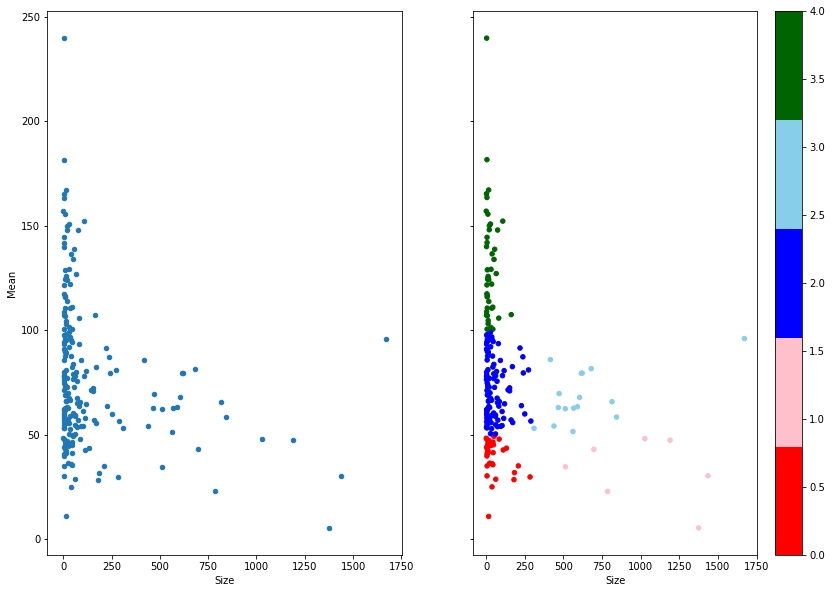

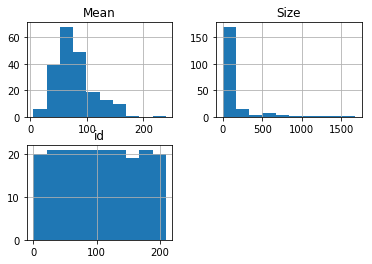

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharey=True)

# 1.普通のプロット

dff.plot(x='Size', y='Mean', kind='scatter', ax=axes.flatten()[0])
dff.plot(x='Size', y='Mean', kind='scatter', ax=axes.flatten()[1], c=c, cmap=cmap)
dff.hist()
# for x, y in dff.iterrows():
#     axes[1].annotate(int(y[0]), xy=(y[1],y[0]), size=2)
# # 2.離散値を色で表す
# df[0:150].plot(x='ad', y='ba', kind='scatter', c='ef', cmap='Blues', ax=axes.flatten()[1])
# # 3.離散値をバブルサイズで表す（ちょっと数は減らしてる）
# df[0:150].plot.scatter(x='ad', y='ba', s=(df['su']-20)*3, ax=axes.flatten()[2])
# # 4.両方同時に使う
#df[0:150].plot.scatter(x='ad', y='ba', s=(df['su']-20)*3, c='ef', ax=axes.flatten()[3])

## Make random dataset

In [3]:
import numpy as np
import random

In [7]:
sw =  ['002', '007', '019', '021', '028', '035', '037', '038', '044', '046', '053', '068', '080', '083', '093', '094', '095', '099', '103', '106', '113', '127', '133', '134', '137', '145', '146', '155', '173', '176', '185', '193', '196', '197', '207']
bw =  ['042', '056', '067', '070', '102', '114', '139']
sm =  ['001', '003', '004', '006', '011', '012', '013', '024', '026', '027', '029', '031', '032', '039', '040', '045', '047', '048', '049', '050', '051', '052', '054', '057', '058', '060', '061', '062', '063', '064', '065', '066', '072', '074', '075', '076', '081', '084', '085', '086', '087', '089', '090', '091', '101', '104', '105', '108', '110', '112', '117', '118', '119', '121', '122', '124', '125', '126', '129', '130', '132', '136', '138', '141', '143', '144', '147', '148', '149', '150', '152', '153', '154', '156', '157', '159', '160', '162', '163', '164', '166', '169', '170', '171', '174', '175', '178', '179', '180', '183', '184', '187', '188', '190', '191', '195', '199', '200', '203', '204', '205', '206', '208', '209']
bm =  ['008', '025', '030', '055', '073', '078', '079', '088', '092', '107', '135', '172', '181', '186', '189', '192']
sb =  ['000', '009', '010', '014', '015', '016', '017', '018', '020', '022', '023', '033', '034', '036', '041', '043', '059', '069', '071', '077', '082', '096', '097', '098', '100', '109', '111', '115', '116', '120', '123', '128', '131', '140', '142', '158', '161', '167', '168', '177', '182', '198', '201', '202']
bb =  []
ignorePatient = ["005","151","165","194"]

In [8]:
random.shuffle(sw)
random.shuffle(bw)
random.shuffle(sm)
random.shuffle(bm)
random.shuffle(sb)
random.shuffle(bb)

In [12]:
a = len(sw)
b = len(bw)
c = len(sm)
d = len(bm)
e = len(sb)
f = len(bb)

        
validation = sw[:int(a/7)] + bw[:int(b/7)] + sm[:int(c/7)] \
              + bm[:int(d/7)] + sb[:int(e/7)] + bb[:int(f/7)] \

testing = sw[int(a/7):int(a/7)*2] + bw[int(b/7):int(b/7)*2] + sm[int(c/7):int(c/7)*2] \
              + bm[int(d/7):int(d/7)*2] + sb[int(e/7):int(e/7)*2] + bb[int(f/7):int(f/7)*2] \

training = sw[int(a/7)*2:] + bw[int(b/7)*2:] + sm[int(c/7)*2:] \
              + bm[int(d/7)*2:] + sb[int(e/7)*2:] + bb[int(f/7)*2:] \
              

    
print(len(validation))
print(len(testing))
print(len(training))
# testing.append("151")
# training.remove("151")
# x = random.randint(0,len(testing))
# training.append(testing[x])
# testing.remove(testing[x])
    
cnt = 0
ccc = validation+testing+training
while len(training)!=150:
    x = random.randint(0,len(training))
    testing.append(training[x])
    training.remove(training[x])
    x = random.randint(0,len(training))
    validation.append(training[x])
    training.remove(training[x])
    
print(len(validation))
print(len(testing))
print(len(training))

print("validation = ",validation)
print("training = ", training)
print("testing = ", testing)
for x in validation:
    if x in ignorePatient:
        print(x)

28
28
150
28
28
150
validation =  ['007', '145', '173', '021', '019', '067', '141', '045', '074', '199', '130', '184', '087', '117', '148', '170', '063', '091', '163', '188', '008', '079', '116', '016', '123', '096', '111', '015']
training =  ['068', '099', '037', '046', '196', '038', '080', '103', '113', '207', '094', '134', '095', '146', '137', '106', '185', '127', '028', '155', '093', '002', '053', '193', '133', '114', '056', '070', '139', '042', '195', '105', '011', '032', '112', '054', '051', '206', '187', '147', '191', '132', '064', '065', '006', '174', '204', '031', '159', '101', '118', '124', '152', '166', '072', '150', '160', '026', '164', '190', '138', '179', '039', '149', '049', '178', '040', '081', '085', '121', '157', '075', '062', '108', '029', '013', '090', '104', '060', '205', '203', '143', '183', '066', '169', '156', '027', '058', '154', '052', '180', '209', '048', '001', '153', '200', '110', '050', '122', '089', '084', '012', '144', '086', '024', '061', '135', '181', 

In [10]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import glob
import os

In [27]:
training = ['207', '080', '095', '099', '007', '028', '053', '137', '176', '106', '083', '127', '094', '103', '193', '019', '197', '037', '196', '035', '113', '146', '185', '093', '145', '102', '056', '042', '139', '067', '180', '061', '026', '174', '153', '001', '064', '075', '091', '129', '147', '058', '178', '085', '086', '203', '003', '138', '144', '051', '122', '024', '076', '205', '121', '063', '108', '027', '188', '184', '004', '160', '119', '164', '045', '130', '072', '049', '166', '154', '209', '143', '013', '163', '074', '081', '048', '052', '126', '087', '149', '117', '136', '012', '206', '040', '191', '054', '124', '066', '195', '187', '132', '057', '150', '060', '089', '104', '170', '159', '171', '169', '039', '125', '199', '011', '008', '073', '055', '107', '079', '092', '192', '030', '186', '181', '088', '172', '034', '018', '120', '082', '177', '014', '158', '109', '100', '131', '033', '010', '140', '069', '022', '123', '071', '023', '098', '116', '128', '043', '059', '161', '115', '097', '167', '017', '015', '201', '096', '202']
ignorePatient = ["005","151","165","194"]

In [51]:
data10 = {"mean" : [], "var" : []}
for x in training:
    sx = str(x).zfill(3)
    
    if sx in ignorePatient:
        continue
        
    paths0 = glob.glob(os.path.join("E:\slice\layers_1_hist_org\image\case_00" + sx, "image0_*.mha"))
    paths1 = glob.glob(os.path.join("E:\slice\layers_1_hist_org\image\case_00" + sx, "image1_*.mha"))
    
    
    mean = [0,0]
    var = [0,0]
    check = True
    for path0, path1 in zip(paths0, paths1):
        img0 = sitk.ReadImage(path0)
        img1 = sitk.ReadImage(path1)
        img0Array = sitk.GetArrayFromImage(img0)
        img1Array = sitk.GetArrayFromImage(img1)
        
        if check:
            check = False
            img0Arrays = img0Array
            img1Arrays = img1Array
        
        else:
            img0Arrays = np.dstack([img0Arrays, img0Array])
            img1Arrays = np.dstack([img1Arrays, img1Array])
        
    data10["mean"].append([img0Arrays.mean(), img1Arrays.mean()])
    data10["var"].append([img0Arrays.var(), img1Arrays.var()])

In [52]:
print(np.array(data25["mean"]).mean(), np.array(data25["var"]).mean())
print(np.array(data50["mean"]).mean(), np.array(data50["var"]).mean())
print(np.array(data75["mean"]).mean(), np.array(data75["var"]).mean())
print(np.array(data10["mean"]).mean(), np.array(data10["var"]).mean())

12.218994473904107 214879.4315322188<br>
12.570158569339881 117897.898996187<br>
12.920030214222686 50587.0624435342<br>
11.863239299971964 341530.5333371568<br>

In [53]:
import csv # csvモジュールをインポート

In [56]:
with open("data25.csv", "w") as f: # 文字コードをShift_JISに指定
    writer = csv.writer(f, lineterminator="\n") # writerオブジェクトの作成 改行記号で行を区切る
    writer.writerows(data25["mean"]) # cs

## Make dataframe about alpha=0.25, 0.50, 0.75 (It doesn't finished)

In [ ]:
kidID = []
kidsNumber = []
kidTag = []
kidMean = []
kidStd = []
kidVar = []
kidMax = []
kidMin = []

canID = []
cansNumber = []
canTag = []
canMean = []
canStd = []
canVar = []
canMax = []
canMin = []

for x in range(210):
    
    sx = str(x).zfill(3)
    
    if sx in ignorePatient:
        continue
        
    paths0 = glob.glob(os.path.join("E:\slice\layers_1_hist_org_0.25\image\case_00" + sx, "image0_*.mha"))
    paths1 = glob.glob(os.path.join("E:\slice\layers_1_hist_org_0.25\image\case_00" + sx, "image1_*.mha"))
    
    for path0, path1 in zip(paths0, paths1):
        img0 = sitk.ReadImage(path0)
        img1 = sitk.ReadImage(path1)
        img0Array = sitk.GetArrayFromImage(img0)
        img1Array = sitk.GetArrayFromImage(img1)
    
    ## Extracting data is finished

    for y in range(sliceNumber):
        imgArray = imageArray[y,:,:]
        labArray = labelArray[y,:,:]
        
        kidIndex = np.where(labArray==1)
        canIndex = np.where(labArray==2)
        
        if kidIndex[0].size!=0:
            kidImgArray = imgArray[kidIndex]
            kidMean.append(kidImgArray.mean())
            kidStd.append(kidImgArray.std())
            kidVar.append(kidImgArray.var())
            kidMax.append(kidImgArray.max())
            kidMin.append(kidImgArray.min())
        else:
            kidMean.append(None)
            kidStd.append(None)
            kidVar.append(None)
            kidMax.append(None)
            kidMin.append(None)
        
        if canIndex[0].size!=0:
            canImgArray = imgArray[canIndex]
            canMean.append(canImgArray.mean())
            canStd.append(canImgArray.std())
            canVar.append(canImgArray.var())
            canMax.append(canImgArray.max())
            canMin.append(canImgArray.min())
        
        else:
            canMean.append(None)
            canStd.append(None)
            canVar.append(None)
            canMax.append(None)
            canMin.append(None)
            
        kidID.append(x)
        kidsNumber.append(y)
        
        canID.append(x)
        cansNumber.append(y)
        
        kidTag.append("kidney")
        canTag.append("cancer")
    
ID = kidID + canID
sNumber = kidsNumber + cansNumber
Tag = kidTag + canTag
Mean = kidMean + canMean
Std = kidStd + canStd
Var = kidVar + canVar
Max = kidMax + canMax
Min = kidMax + canMin

df["id"] = ID
df["slice number"] = sNumber
df["tag"] = Tag
df["Mean"] = Mean
df["Std"] = Std
df["Var"] = Var
df["Max"] = Max
df["Min"] = Min


print(df)
df.set_index(["id", "slice number", "tag"], inplace=True)
print(df)
df.to_csv('sagital1.csv', sep=',', index=True, index_label = ["id", "slice number", "tag"])

In [2]:
import matplotlib.pyplot as plt

In [4]:
with open('/home/vmlab/Desktop/KIDNEY/text/result.txt') as f:
    file = f.readlines()

In [5]:
alpha = []
dice =[]
for x in file:
    xx = x.split()
    if xx[0][1].lower()=='l':
        alpha.append(1.0 - float(xx[1].replace('<br>', '')))
    elif xx[1][0].lower()=='c':
        dice.append(float(xx[2].replace('<br>', '')))
        
for x, y in zip(alpha, dice):
    print(x,y)

1.0 0.6168616106368008
0.95 0.6427303569773539
0.9 0.6331813067769961
0.85 0.6142015511082867
0.8 0.6127422154373728
0.75 0.6390143488447617
0.7 0.6144467124985238
0.6 0.6189194623422858
0.55 0.6227715693641677
0.5 0.6332673342763784
0.44999999999999996 0.6330643159830883
0.4 0.6154617736995323
0.35 0.6162038113721422
0.30000000000000004 0.6194164344665026
0.25 0.619761210861021
0.19999999999999996 0.6227163976428916
0.15000000000000002 0.615614442828826
0.09999999999999998 0.6066524546095309
0.050000000000000044 0.6128789202649746
0.0 0.6330005107201063


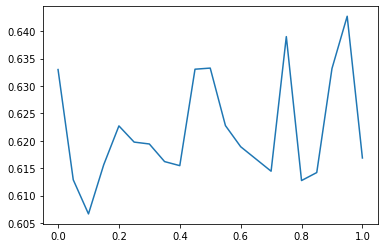

In [6]:
plt.plot(alpha, dice)

In [2]:
import SimpleITK as sitk
import numpy as np
import sys
import matplotlib.pyplot as plt

In [88]:
img = sitk.ReadImage('/home/vmlab/Desktop/data/slice/original/image/case_00000/image0_13.mha')
imgArray = sitk.GetArrayFromImage(img)
print(imgArray.shape)
print(imgArray.max(), imgArray.min())

(256, 256)
770.6985426754006 -176.50363717769574


In [89]:
times = 10**3

In [90]:
print(imgArray[33][33])
print(imgArray.min(), imgArray.max())

imgArray = imgArray + 1024
imgArray = np.clip(imgArray, 0, 2048)
imgArray = imgArray * times

-103.72275289304488
-176.50363717769574 770.6985426754006


In [91]:
ctRange = 2048 * times + 1

In [93]:
hist,_ = np.histogram(imgArray, bins=ctRange, range=[0, ctRange ], density=True)

hist.max()

0.0077972412109375

In [ ]:
HIST = np.array([0.0] * ctRange)

for x in range(210):
    sx = str(x).zfill(3)
    if sx not in training:
        continue

    p = Path('/home/vmlab/Desktop/data/slice/hist_1.0/image/case_00' + sx)
    if not p.exists():
        print('File does not exist. ')
        sys.exit()
    for i in p.glob('image*'):
        img = sitk.ReadImage(str(i))
        imgArray = sitk.GetArrayFromImage(img)
        imgArray = imgArray + 1024
        imgArray = np.clip(imgArray, 0, 2048)
        hist, _ = np.histogram(imgArray.ravel(), ctRange, [0, ctRange], density=True)
        HIST += hist
    print('case_00' + sx + 'done. ')

HIST = HIST / HIST.sum()

In [15]:
import os

In [79]:
hists = np.load('/home/vmlab/Desktop/data/sumHistFloat.npy')
times = 10**3 #args
alpha = 1.0  #args

In [80]:
print('Loading npy file...')
npyFile = os.path.expanduser('/home/vmlab/Desktop/data/sumHistFloat.npy')
HIST = np.load(npyFile)
print('Loading it has done. ')
aHIST = HIST * alpha + (1 - alpha) / (2048 * times)

#Make CDF
cdf = aHIST.cumsum()
cdf_m = np.ma.masked_equal(cdf,0)
temp = (cdf_m - cdf_m.min())/(cdf_m.max()-cdf_m.min())
cdf_m = 2048 * times * temp
cdfI = np.ma.filled(cdf_m,0).astype('int')
cdfF = np.ma.filled(cdf_m,0).astype('float32')
print('Making CDF has done.' )
print(cdfI)
print(cdfF)

Loading npy file...
Loading it has done. 
Making CDF has done.
[      0       0       0 ... 2047928 2047928 2048000]
[0.0000000e+00 0.0000000e+00 2.3323635e-03 ... 2.0479285e+06 2.0479285e+06
 2.0480000e+06]


In [81]:
img = sitk.ReadImage('/home/vmlab/Desktop/data/slice/original/image/case_00000/image0_13.mha')
imgArray = sitk.GetArrayFromImage(img)
imgArray = imgArray + 1024
imgArray = np.clip(imgArray, 0, 2048)
imgArray = imgArray * times

print(imgArray)
print()
imgArray = np.array(imgArray, dtype=np.int)
print('aa',imgArray)
print('bb',cdfI[imgArray])
print('cc',cdfF[imgArray])

imgArray = cdfF[imgArray] 
imgArray = imgArray / times - 1024

print('dd', imgArray)

i = sitk.ReadImage('/home/vmlab/Desktop/KIDNEY/test/image/case_00000/image0_13.mha')
ia = sitk.GetArrayFromImage(i)
print('ee',ia)

[[ 938983.93487945  942176.1513168   945368.36775415 ...  930011.43702338
   927301.56610797  847496.3628223 ]
 [ 930110.69712646  934261.25461847  938411.81211049 ...  937850.43450953
   935682.6958195   847496.3628223 ]
 [ 921237.45937347  926346.35792015  931455.25646683 ...  945689.43199568
   944063.82553104  847496.3628223 ]
 ...
 [1440411.97717126 1446222.70509205 1452033.43301283 ... 1067320.78257631
  1067395.41075891  847496.3628223 ]
 [1440411.97717126 1446222.70509205 1452033.43301283 ... 1067320.78257631
  1067395.41075891  847496.3628223 ]
 [ 847496.3628223   847496.3628223   847496.3628223  ...  847496.3628223
   847496.3628223   847496.3628223 ]]

aa [[ 938983  942176  945368 ...  930011  927301  847496]
 [ 930110  934261  938411 ...  937850  935682  847496]
 [ 921237  926346  931455 ...  945689  944063  847496]
 ...
 [1440411 1446222 1452033 ... 1067320 1067395  847496]
 [1440411 1446222 1452033 ... 1067320 1067395  847496]
 [ 847496  847496  847496 ...  847496  847496

In [15]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [16]:
alpha = ['0.0', '0.20', '0.40', '0.60', '0.80', '1.0']

for a in alpha:
    i = sitk.ReadImage('/home/vmlab/Desktop/data/slice/summed_hist_' + a + '/image/case_00000/image0_13.mha')
    ia = sitk.GetArrayFromImage(i)
    iaa = sitk.ReadImage('/home/vmlab/Desktop/data/slice/summed_hist_float_' + a + '/image/case_00000/image0_13.mha')
    iaaa = sitk.GetArrayFromImage(iaa)
    print(ia[0, :5], iaaa[0, :5])

[-85 -81 -78 -76 -80] [-85.01703  -81.823975 -78.63202  -76.95599  -80.737976]
[-173 -161 -152 -147 -158] [-171.45227 -161.44293 -152.19415 -147.62878 -158.21442]
[-261 -240 -225 -217 -235] [-257.88898 -241.06323 -225.7575  -218.3028  -235.6922 ]
[-348 -319 -299 -287 -312] [-344.32727 -320.68494 -299.32214 -288.97803 -313.17126]
[-436 -398 -372 -357 -389] [-430.76703 -400.30798 -372.888   -359.65442 -390.6516 ]
[-524 -477 -446 -427 -466] [-517.2081  -479.93237 -446.4552  -430.33215 -468.1333 ]


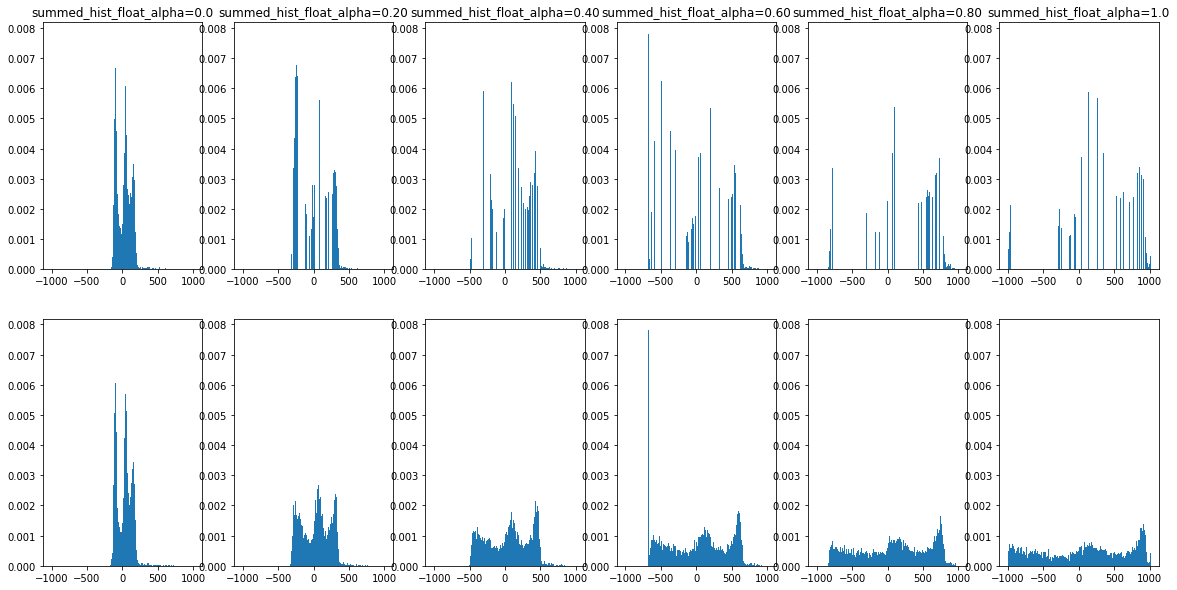

In [46]:
alpha = ['0.0', '0.20', '0.40', '0.60', '0.80', '1.0']
#alpha = ['1.0']
fig, axes = plt.subplots(2 ,6, figsize=(20, 10))
for ii, a in enumerate(alpha):
    i = sitk.ReadImage('/home/vmlab/Desktop/data/slice/summed_hist_' + a + '/image/case_00000/image0_13.mha')
    ia = sitk.GetArrayFromImage(i)
    axes[0][ii].set_title("summed_hist_int_alpha=" + a)
    axes[0][ii].hist(ia.ravel(), 2049, [-1024, 1024], density=True)
    i = sitk.ReadImage('/home/vmlab/Desktop/data/slice/summed_hist_float_' + a + '/image/case_00000/image0_13.mha')
    ia = sitk.GetArrayFromImage(i)
    axes[0][ii].set_title("summed_hist_float_alpha=" + a)
    axes[1][ii].hist(ia.ravel(), 2049, [-1024, 1024], density=True)
   

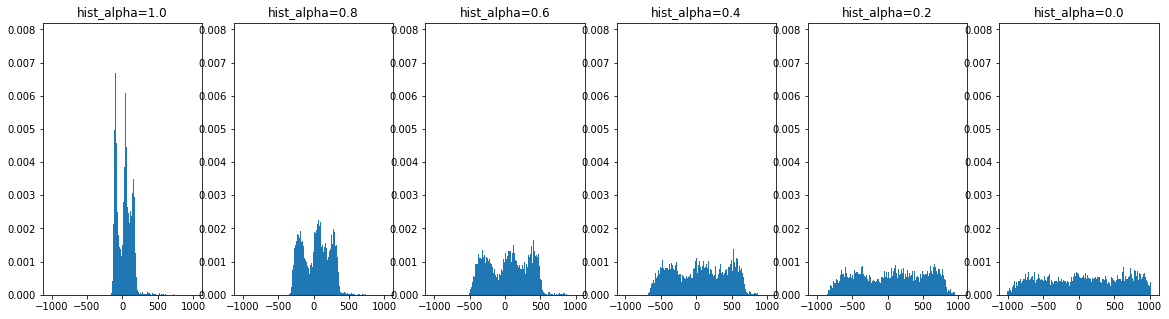

In [45]:
alpha = ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']
alpha.reverse()
fig, axes = plt.subplots(1 ,6, figsize=(20, 5))
for ii, a in enumerate(alpha):
    i = sitk.ReadImage('/home/vmlab/Desktop/data/slice/hist_'+ a + '/image/case_00000/image0_13.mha')
    ia = sitk.GetArrayFromImage(i)
    axes[ii].set_title("hist_alpha=" + a)
    axes[ii].hist(ia.ravel(), 2049, [-1024, 1024], density=True)